### Import libraries

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

### Import data

In [48]:
# kaggle data:
lap_times = pd.read_csv(r"F1_data\lap_times.csv")
drivers = pd.read_csv(r"F1_data\drivers.csv")
results = pd.read_csv(r"F1_data\results.csv")

# scraped data:
circuits = pd.read_csv(r"data_cleaned\circuits.csv")
races = pd.read_csv(r"data_cleaned\races.csv")
engines = pd.read_csv(r"data_cleaned\engines.csv")

# merged data:
teams = pd.read_csv(r"data_cleaned\teams.csv")
lap_speeds = pd.read_csv(r"data_cleaned\lap_speeds.csv")
main_drivers = pd.read_csv(r"data_cleaned\main_drivers .csv")
constructors = pd.read_csv(r"data_cleaned\constructors.csv")

FileNotFoundError: [Errno 2] File b'F1_data\\lap_times.csv' does not exist: b'F1_data\\lap_times.csv'

### Which teams have competed the most since 1996

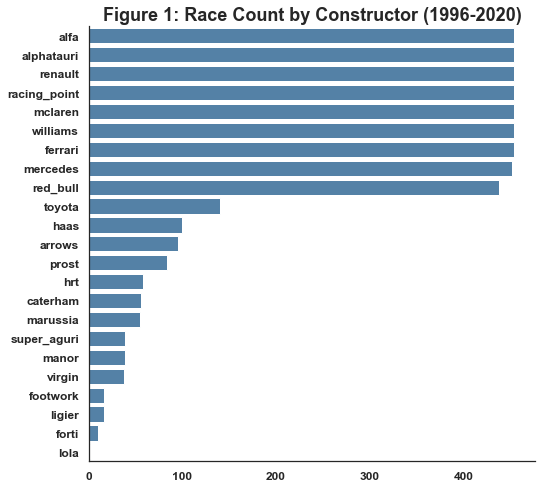

In [16]:
teams2 = teams.loc[teams.year > 1995,:].copy()
teams2['constructorRef_mapped'].fillna(teams2.constructorRef, inplace=True)
race_counts = pd.DataFrame({'race_count' : teams2.groupby(['constructorRef_mapped'])['raceId']
              .nunique()}).reset_index()

sns.set(rc={'figure.figsize':(8,8)})
sns.set(style="white")
    
ax = sns.barplot(x='race_count',
            y="constructorRef_mapped", 
            data=race_counts, 
            orient='h',
            color='steelblue',
            order=race_counts.sort_values('race_count', ascending=False).constructorRef_mapped)

ax.set_title('Figure 1: Race Count by Constructor (1996-2020)', fontsize=18, fontweight='bold')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    tick.label.set_fontweight('bold')
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    tick.label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('')

sns.despine()

### Get some metadata for lap speeds

In [24]:
df = lap_speeds[['raceId', 'year', 'driverId', 'lap', 'position', 'km_per_sec', 'km_per_min']].merge(races[['raceId', 'circuitId']], on ='raceId', how='left')
df = df.merge(teams[['raceId', 'driverId', 'constructorId', 'constructorRef_mapped']], on=['raceId', 'driverId'], how='left')
df = df.merge(circuits[['circuitId', 'circuitRef']], on='circuitId', how='left')
df.head()

lap_stats = pd.DataFrame({'avg_km_min' : df.groupby(['year'])['km_per_min'].mean(),
                          'min_km_min' : df.groupby(['year'])['km_per_min'].min(),
                          'max_km_min' : df.groupby(['year'])['km_per_min'].max()}
                               ).sort_values(['year']).reset_index()

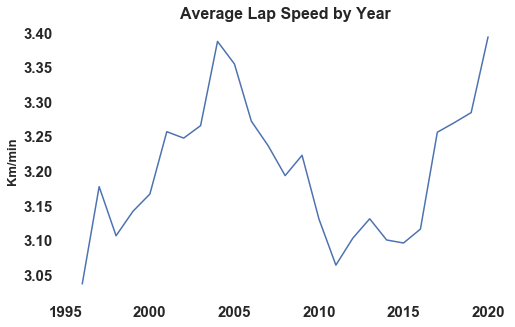

In [19]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set(style="white")

ax = sns.lineplot(x='year',
            y='avg_km_min', 
            data=lap_stats)
    
ax.set_title('Average Lap Speed by Year', fontsize=16, fontweight='bold')
ax.set_ylabel('Km/min', fontsize=13, fontweight='bold')
plt.xlabel('')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')
 

sns.despine(left=True, bottom=True)

### Calculate average lap speed by year and constructor

In [20]:
avg_lap_speed = pd.DataFrame({'avg_lap_speed' : df.groupby(['year', 'constructorRef_mapped'])['km_per_min']
              .mean()}).sort_values(['constructorRef_mapped', 'year']).reset_index()

avg_lap_speed = avg_lap_speed.sort_values(["constructorRef_mapped","year"])
avg_lap_speed = avg_lap_speed.merge(main_drivers, on = ['year', 'constructorRef_mapped'], how='left') 
avg_lap_speed['drivers'] = avg_lap_speed.groupby(['year', 'constructorRef_mapped'])['surname'].transform(lambda x : ', '.join(x))
avg_lap_speed = avg_lap_speed[['year', 'constructorRef_mapped', 'avg_lap_speed', 'drivers']].drop_duplicates()

avg_lap_speed.to_csv(r"graph_data\avg_lap_speed.csv", index=False)

avg_lap_speed.head()

,year,constructorRef_mapped,avg_lap_speed,drivers
0,1996,alfa,2.961613,"Frentzen, Herbert"
2,1997,alfa,3.203475,"Herbert, Morbidelli"
4,1998,alfa,3.095327,"Alesi, Herbert"
6,1999,alfa,3.181770,"Alesi, Diniz"
8,2000,alfa,3.181504,"Diniz, Salo"


In [38]:
constructor_names = {'alfa': 'Alfa Romeo',
                   'alphatauri': 'AlphaTauri',
                   'mclaren': 'McLaren',
                   'mercedes': 'Mercedes',
                   'racing_point': 'Racing Point',
                   'red_bull': 'Red Bull',
                   'renault': 'Renault',
                   'ferrari': 'Ferrari',
                   'haas': 'Haas',
                   'williams': 'Williams'}

line_map = {'mercedes': 'solid',
          'red_bull':   'solid',
          'racing_point': 'dash',
          'mclaren': 'solid',
          'renault': 'solid',
          'ferrari': 'solid',
          'alphatauri': 'dot',
          'alfa': 'dot',
          'haas': 'dash',
          'williams': 'dot'}


col_map = {'mercedes': '#484848',
          'red_bull': '#4575b4',
          'racing_point': '#484848',
          'mclaren': '#fc8d59',
          'renault': '#fee090',
          'ferrari': '#d73027',
          'alphatauri': '#4575b4',
          'alfa': '#d73027',
          'haas': '#d73027',
          'williams': '#484848'}

In [39]:
max_speeds = avg_lap_speed.loc[avg_lap_speed.groupby(['year'])['avg_lap_speed'].idxmax()].reset_index(drop=True)
min_speeds = avg_lap_speed.loc[avg_lap_speed.groupby(['year'])['avg_lap_speed'].idxmin()].reset_index(drop=True)

In [46]:
fig = go.Figure()

df = avg_lap_speed

fig.add_trace(go.Scatter(x=max_speeds['year'], y=max_speeds['avg_lap_speed'],
                         fill=None,
                         mode='lines',
                         line_color='rgb(217, 217, 217)',
                         hovertemplate= '<b>Max Speed: </b>%{y}<br><extra></extra>',
                         showlegend=False))

fig.add_trace(go.Scatter(x=min_speeds['year'], y=min_speeds['avg_lap_speed'],
                         fill='tonexty',
                         mode='lines', line_color='rgb(217, 217, 217)',
                         hovertemplate= '<b>Min Speed: </b>%{y}<br><extra></extra>',
                         name="Average Speed Range"))

for key, grp in df.groupby(['constructorRef_mapped']):
    fig.add_trace(go.Scatter(x=grp['year'], y=grp['avg_lap_speed'],
                             mode='lines',
                             line=dict(color=col_map[key], dash=line_map[key]),
                             name=constructor_names[key],
                             hovertemplate=
                             f'<b>Constructor:</b> {constructor_names[key]} <br>' +
                             '<b>Drivers:</b> %{text}<extra></extra>',
                             text=df.loc[(df.constructorRef_mapped == key), "drivers"], ))

fig.add_vrect(
    x0="1996", x1="2005",
    fillcolor="azure",  # opacity=0.5,
    layer="below", line_width=0,
),

fig.add_vrect(
    x0="2005", x1="2013",
    fillcolor="cornsilk",  # opacity=0.5,
    layer="below", line_width=0,
),

fig.add_vrect(
    x0="2013", x1="2020",
    fillcolor="honeydew",  # opacity=0.5,
    layer="below", line_width=0,
),

fig.add_annotation(x=2005, y=3.53,
                   xref="x", yref="y", ax=1996, ay=3.53,
                   axref="x", ayref="y",
                   arrowhead=5, arrowside="end+start", arrowsize=1.5, arrowcolor='teal')

fig.add_annotation(x=2000.5, y=3.55, text="<b>V10/12 Engines</b>",
                   showarrow=False, font=dict(size=18, color='teal'))

fig.add_annotation(x=2005, y=3.53,
                   xref="x", yref="y", ax=2013, ay=3.53,
                   axref="x", ayref="y",
                   arrowhead=5, arrowside="end+start", arrowsize=1.5, arrowcolor='IndianRed')

fig.add_annotation(x=2009, y=3.55, text="<b>V8 Engines</b>",
                   showarrow=False, font=dict(size=18, color='IndianRed'))

fig.add_annotation(x=2020, y=3.53,
                   xref="x", yref="y", ax=2013, ay=3.53,
                   axref="x", ayref="y",
                   arrowhead=5, arrowside="end+start", arrowsize=1.5, arrowcolor='darkgreen')

fig.add_annotation(x=2016.5, y=3.55, text="<b>V6 Hybrid Engines</b>",
                   showarrow=False, font=dict(size=18, color='darkgreen'))

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,

    plot_bgcolor='rgba(0,0,0,0)',

    title=dict(
        text="<b>Average Speed by Constructor</b>",
        xanchor='left',
        yanchor='top',
        y=0.92,
        x=0.12
    ),

    #legend=dict(
    #    title_text="<b>Constructors</b>",
    #),

    yaxis=dict(
        range=[2.9, 3.58],
        title_text="<b>Km/min</b>",
        tickwidth=2,
        ticks="outside",
        ticklen=10,
        tickprefix="<b>", ticksuffix="</b>",
        tickfont=dict(size=15),
        showline=True,
        linewidth=2,
        linecolor='black',
        gridcolor='lightGray'
    ),

    xaxis=dict(
        range=[1995, 2021],
        tick0=1996,
        dtick=2,
        title_text="<b>Year</b>",
        tickwidth=2,
        ticks="outside",
        tickprefix="<b>", ticksuffix="</b>",
        ticklen=10,
        showline=True,
        linewidth=2,
        linecolor='black',
        gridcolor='lightGray'
    ),

    font=dict(
        size=15,
        color='black')
)


fig.show()